# <i class="fas fa-circle" style="color: #f0ad4e;"></i> Generalising regression
<span style="background-color: #f0ad4e; color: white; border-radius: 10px; padding-top: 2px; padding-bottom: 2px; padding-left: 6px;padding-right: 6px;">exercise</span><span style="background-color: #343A40; color: white; border-radius: 10px; padding-top: 2px; padding-bottom: 2px; padding-left: 6px;padding-right: 6px;">notebook</span>

$$ 
\newcommand{\mat}[1]{\begin{bmatrix}#1\end{bmatrix}} 
\renewcommand{\vec}[1]{\mathbf{#1}}
%\newcommand{\norm}[2][{}]{\|#2\|_{#1}} 
$$


In [3]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


In this exercise you will generalise regression to $N$th order polynomials and use it to predict the price of a house (in Canadian dollars) based on its lot size (in square feet).

Suppose you want to buy a house in the City of Windsor, Canada. You contact a real-estate salesperson to get information about current house prices and receive details on 546 properties sold in Windsor in the last two years. You would like to figure out what the expected cost of a house might be given only the lot size of the house you want to buy. Fortunately, his dataset has only one independent variable (i.e. `lotsize`, the lot size of a property) and one dependent variable (i.e. `price`, the sale price of a house). You will train the dataset using polynomial regression to predict the house prices.

A polynomial *model* of order $N$ is defined by:

$$
f_\theta(x) = \theta_0 + \theta_1 x + \theta_2 x^2 + \dots + \theta_N x^N,
$$

in which, the coefficients $\theta_i$ are the parameters of the model. Notice how the function is linear in the parameters, i.e. if $x$ is fixed, the function is linear. To estimate the parameters $\theta_i$, you can therefore setup a linear equation and solve for $\theta$:

$$
\begin{bmatrix}
    1 & x_1 & x_1^2 & x_1^3 & \dots & x_1^N \\
    1 & x_2 & x_2^2 & x_2^3 & \dots & x_2^N \\
    1 & x_3 & x_3^2 & x_3^3 & \dots & x_3^N \\
    \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & x_m & x_m^2 & x_m^3 & \dots & x_m^N
\end{bmatrix}
\times
\begin{bmatrix}
    \theta_0 \\
    \theta_1 \\
    \theta_2 \\
    \theta_3 \\
    \vdots \\
    \theta_N
\end{bmatrix}
=
\begin{bmatrix}
    y_1 \\
    y_2 \\
    y_3 \\
    \vdots \\
    y_m
\end{bmatrix},
$$

or more compactly: $A \theta = y$. 

The *cost function* $\ell(\mathbf{\hat{y}}, \mathbf{y})$ for linear regression is the mean squared error between the known outputs $y_i$ and the predicted outputs $f_{\theta}(x)$ of the model:

$$
\begin{equation}
\ell(\mathbf{\hat{y}}, \mathbf{y}) = (f_{\theta}(x_{i})-y_{i})^2
\end{equation}
$$

This cost function is simply the squarred error of each point. We know from the projection method that least squares minimises the sum of squares. In other words, the parameters $\theta$ can be decided by solving the following optimisation problem:

$$
\begin{equation}
\theta = \underset{\theta}{\operatorname{argmin}} \frac{1}{m}\sum_{i=1}^{m} \ell(f(x_i), \mathbf{y_i})
\end{equation}
$$

Just to summarize, we have our *model* $f_\theta(x)$ which is a polynomial function in $x$. We then want to find parameters $\theta$ that minimizes the squared distance (the $\frac{1}{m}$ is just for scaling). We know from linear algebra that projecting the vector $(f(x_1), \dots, f(x_m)$ onto the column space of the design matrix defined by $A$ is equivalent to solving that optimisation problem.


## 5.1 Data exploration

We start by loading the dataset described above:


In [4]:
filename = "../inputs/simple_windsor.csv"
names = ["lotsize", "price"]
dataset = np.loadtxt(filename, delimiter=',', dtype=np.int32)

X_full, y_full = dataset.T


Let us visualise the data:


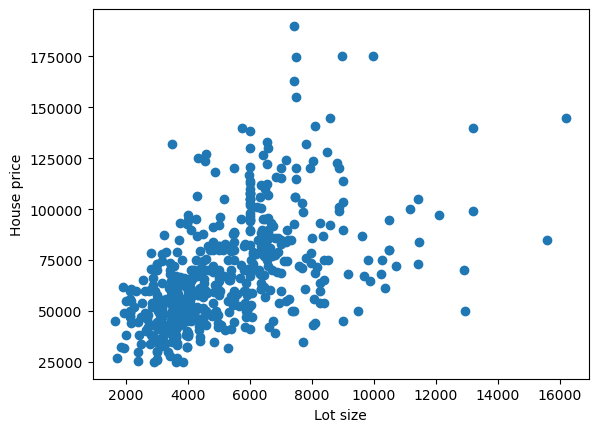

In [5]:
plt.scatter(X_full, y_full)
plt.xlabel('Lot size')
plt.ylabel('House price');


This visualisation already tells us a lot about the usefulnes of the data. Try to answer the following questions to the best of your abilities:

### Task (A)
1. Notice the large spread in house prices for relatively similar lot sizes. Can you relate this to a real-world phenomenon? In other words, is it realistic to expect that the price of a house is determined solely by the lot size?
2. Can you imagine other factors that might be useful for modelling house prices?
3. Can you think of a method to evaluate how useful a given factor is in predicting the house price?


In [6]:
# 1)
# Other apsects than the lot size might affect the house price.
# For example, quality and location might affect the price drastically.
# So, it is not realistic to expect that the price is only determined by the size

# 2)
# As mentioned, quality, location, etc.

# 3)
# Make comparisons between the other factors and the price.
# Whichever visualisation is closest to a linear line (the least noice) could be said to be most useful in predicting the house price.

### Splitting into train and test data
We use a helper function from the *Scikit Learn* library to split the dataset into $80\%$ training data and $20\%$ test data:


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)


## 5.2 Generalising regression
First, we need to be able to generate design matrices as described above from a single input vector `X`. We provide the function below for creating design matrices for polynomials of arbitrary order:


In [8]:
def get_design_matrix(x, order=1):
    """
    Get the coefficients of polynomial in a least square sense of order N.
    
    :param x: Must be numpy array of size (N).
    :order n: Order of Polynomial.
    """
    
    if order < 1 or x.ndim != 1:
        return x

    count = x.shape[0]
    matrix = np.ones((count, order + 1), np.float64)

    for i in range(1, order+1):
        matrix[:, i] = np.power(x, i)

    return matrix


### Task (B)
1. **Estimate parameters:** Implement the function `estimate(X, y, order)` below. The function should use `np.linalg.lstsq()` to estimate parameters for the model. Use `get_design_matrix(X, order)` to generate an appropriate design matrix.


In [9]:
def estimate(X, y, order):
    """
    :param X: Input vector.
    :param y: Training data values.
    :param order: Order of the model to estimate.
    
    :return: Parameters of model.
    """
    dm = get_design_matrix(X, order)
    #Pm = np.linalg.inv(dm.T.dot(dm)).dot(dm.T)
    #params = Pm.dot(X[:])
    #theta = np.dot(np.linalg.inv(dm), y)
    params = np.linalg.lstsq(dm, y)
    return params


2. **Model:** Implement the function `linear_model(X, params)` below. It should compute the house price `y` for a given feature vector `X`


In [10]:
def linear_model(X, params):
    """
    :param X: Input vector.
    :param params: Estimated parameters.
    
    :return: Predicted y-values.
    """
    #print(X)
    #print(params[0])
    #y = X*params[0] + params[1]
    y = 0
    for p in range(len(params[0])-1, -1, -1):
        y += np.power(X, p) * params[0][p]
    #y = (X*X)*params[0][2] + X*params[0][1] + params[0][0]
    return(y)


3. **Prediction:** The variable `values` contains the integer values between the minimum and maximum lot sizes from the dataset. (A) Estimate parameters from `X_train` and `y_train`. (B) Then calculate the predicted `y`-values for `values` using the estimated parameters. (C) Plot the predicted values as a line-plot.


[[1.0000e+00 8.5000e+03]
 [1.0000e+00 7.7700e+03]
 [1.0000e+00 6.3600e+03]
 [1.0000e+00 4.9900e+03]
 [1.0000e+00 3.6000e+03]
 [1.0000e+00 6.0000e+03]
 [1.0000e+00 9.5000e+03]
 [1.0000e+00 5.2000e+03]
 [1.0000e+00 8.5800e+03]
 [1.0000e+00 1.5600e+04]
 [1.0000e+00 6.0000e+03]
 [1.0000e+00 4.0400e+03]
 [1.0000e+00 6.4200e+03]
 [1.0000e+00 6.5400e+03]
 [1.0000e+00 4.0750e+03]
 [1.0000e+00 6.0000e+03]
 [1.0000e+00 4.3200e+03]
 [1.0000e+00 7.4400e+03]
 [1.0000e+00 4.0950e+03]
 [1.0000e+00 8.9600e+03]
 [1.0000e+00 3.8500e+03]
 [1.0000e+00 4.9000e+03]
 [1.0000e+00 2.4300e+03]
 [1.0000e+00 4.1200e+03]
 [1.0000e+00 6.5400e+03]
 [1.0000e+00 2.1450e+03]
 [1.0000e+00 4.8000e+03]
 [1.0000e+00 2.8000e+03]
 [1.0000e+00 1.6200e+04]
 [1.0000e+00 8.0800e+03]
 [1.0000e+00 8.4000e+03]
 [1.0000e+00 1.3200e+04]
 [1.0000e+00 4.3520e+03]
 [1.0000e+00 4.0400e+03]
 [1.0000e+00 5.4000e+03]
 [1.0000e+00 3.5200e+03]
 [1.0000e+00 3.9860e+03]
 [1.0000e+00 5.7500e+03]
 [1.0000e+00 2.4000e+03]
 [1.0000e+00 3.6500e+03]


C:\Users\mikke\AppData\Local\Temp\ipykernel_5092\4013865950.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(dm, y)


[]

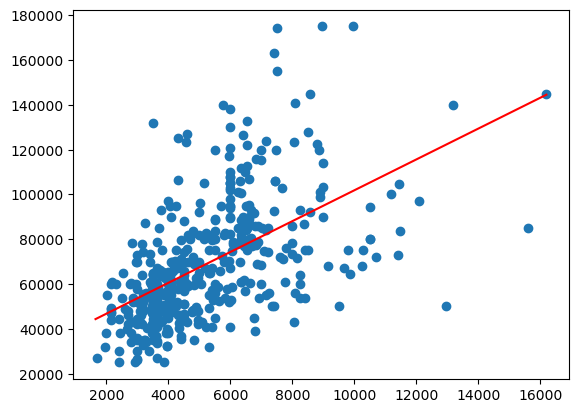

In [24]:
from turtle import color


values = np.linspace(X_full.min(), X_full.max(), 50)

# (A) Estimate parameters
estimatedParameters = estimate(X_train, y_train, 1)
print(estimatedParameters)

# (B) Evaluate model
predictedYs = linear_model(values, estimatedParameters)
#print(predictedYs)

plt.scatter(X_train, y_train)

# (C) Plot predicted values
plt.plot(values, predictedYs, color='r')
plt.plot()


4. **Increasing orders:** Try to use higher order polynomials in the estimation and prediction code above. You should see the predictions starting to deviate drastically for orders above 3 or 4. Do you have any idea why this happens? *Hint: It has to do with the behavior of floating point numbers at extreme values.*


The above problem can be solved simply by normalizing the *lot sizes*. We provide the following functions for easy normalization and unnormalization:


In [12]:
def normalized(X):
    n = (X - np.min(X_full))/np.max(X_full)
    return n

def unnormalized(X):
    return X*np.max(X_full) + np.min(X_full)


5. **Normalization:** Redo the estimation from task B3 above but with normalized values for `X_train`. Plot the results and experiment with different values for the order. 


[[1.0000e+00 8.5000e+03]
 [1.0000e+00 7.7700e+03]
 [1.0000e+00 6.3600e+03]
 [1.0000e+00 4.9900e+03]
 [1.0000e+00 3.6000e+03]
 [1.0000e+00 6.0000e+03]
 [1.0000e+00 9.5000e+03]
 [1.0000e+00 5.2000e+03]
 [1.0000e+00 8.5800e+03]
 [1.0000e+00 1.5600e+04]
 [1.0000e+00 6.0000e+03]
 [1.0000e+00 4.0400e+03]
 [1.0000e+00 6.4200e+03]
 [1.0000e+00 6.5400e+03]
 [1.0000e+00 4.0750e+03]
 [1.0000e+00 6.0000e+03]
 [1.0000e+00 4.3200e+03]
 [1.0000e+00 7.4400e+03]
 [1.0000e+00 4.0950e+03]
 [1.0000e+00 8.9600e+03]
 [1.0000e+00 3.8500e+03]
 [1.0000e+00 4.9000e+03]
 [1.0000e+00 2.4300e+03]
 [1.0000e+00 4.1200e+03]
 [1.0000e+00 6.5400e+03]
 [1.0000e+00 2.1450e+03]
 [1.0000e+00 4.8000e+03]
 [1.0000e+00 2.8000e+03]
 [1.0000e+00 1.6200e+04]
 [1.0000e+00 8.0800e+03]
 [1.0000e+00 8.4000e+03]
 [1.0000e+00 1.3200e+04]
 [1.0000e+00 4.3520e+03]
 [1.0000e+00 4.0400e+03]
 [1.0000e+00 5.4000e+03]
 [1.0000e+00 3.5200e+03]
 [1.0000e+00 3.9860e+03]
 [1.0000e+00 5.7500e+03]
 [1.0000e+00 2.4000e+03]
 [1.0000e+00 3.6500e+03]


C:\Users\mikke\AppData\Local\Temp\ipykernel_5092\4013865950.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(dm, y)


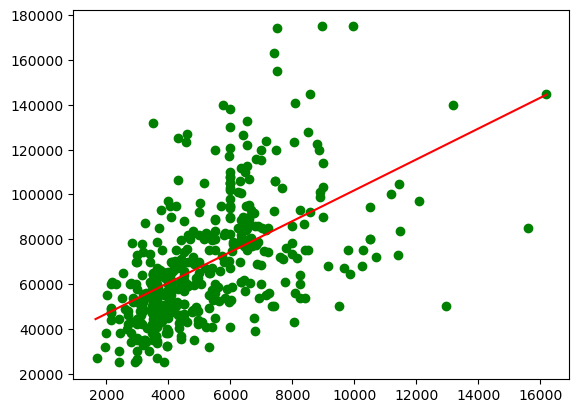

In [13]:
values = np.linspace(X_full.min(), X_full.max(), 50)

# Estimate parameters and predict y-values

plt.scatter(X_train, y_train, c="g")

# (A) Estimate parameters
estimatedParameters = estimate(X_train, y_train, 1)

# (B) Evaluate model
predictedYs = linear_model(values, estimatedParameters)

# (C) Plot predicted values
plt.plot(values, predictedYs, color='r')

## 5.3 Evaluation
We now want to evaluate the model using the test data. You will calculate the *root mean squarred error* for various orders of polynomials and use the error to decide which order has the best tradeoff between bias and variance (underfitting/overfitting).

The *root mean squared error* is simply the square root of the *mean squared error*: 
$$
 \sqrt{\frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x_{i})-y_{i})^2}
$$
We use it because it represents the average error in the same units as the data, i.e. house prices in our case.


### Task (C)
1. **Error function:** Implement the `rmse` function below. Remember to normalize the X-values.


In [14]:
def rmse(theta, X, y):
    X = normalized(X)
    print(theta[0])
    sum = 0
    for i in range(0, len(X)):
        sum += np.power((theta[0][1] * X[i]) - y[i], 2)
    np.sqrt((1/len(X)) * sum)


2. **Test models:** Finish the implementation of `test_models` below. It should estimate parameters for a given order polynomial using the training data and then record the train and test losses using the `rmse` function.


In [15]:
def test_models():
    losses_train = []
    losses_test = []
    for order in range(1, 20):
        # Add code here
        rmse_train = rmse(estimate(X_train, y_train, order), X_train, y_train)
        rmse_test = rmse(estimate(X_test, y_test, order), X_test, y_test)
        losses_train.append(rmse_train)
        losses_test.append(rmse_test)
    return losses_train, losses_test


3. **Plot both losses:** Plot the losses. Are the results what you expected? How does this relate to the dilemma of underfitting and overfitting? 


In [16]:

#plt.plot(test_models())

# As expected, the losses become lower to a certain point in the given order polynomial.
# When underfitting, the fit may not recognize a very ideal exponential curve or something the like.
# On the opposite hand, when overfitting, it becomes harder to predict where a new point would lie, and the losses therefore increase.


### Task (D)
1. What does the loss plots tell you about the precision of the models in general?
2. Would you be able to improve the test loss to an arbitrary low value using a different model? If yes, explain what model you might use. If no, explain why not.
